# PDF RAG Agent Flow Diagram

> 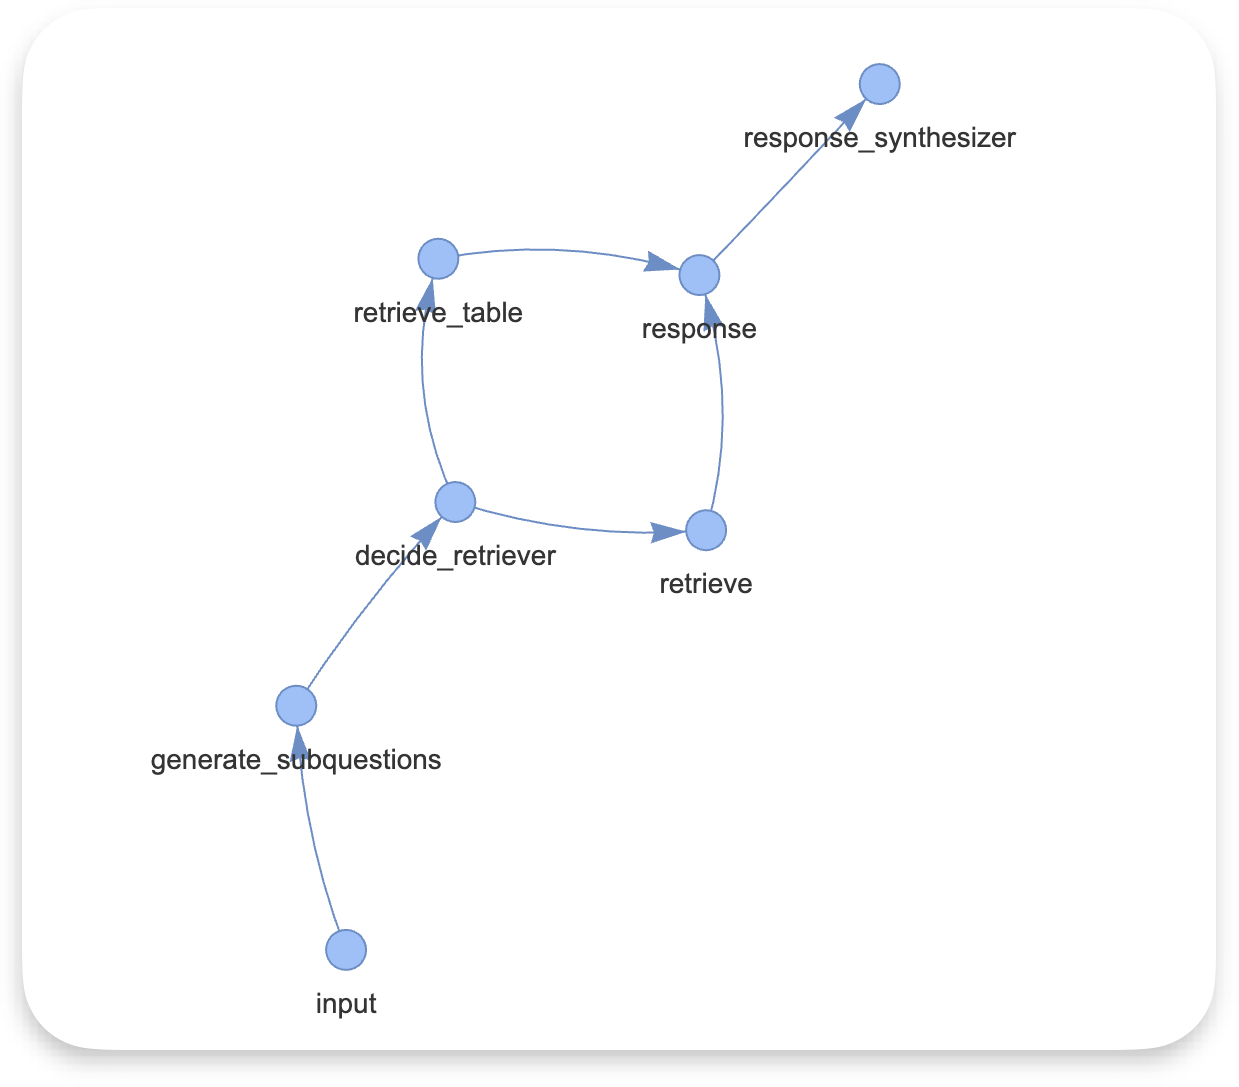

# Install Packages

In [1]:
!pip install llama-index-llms-huggingface llama-index-embeddings-huggingface --quiet
!pip install transformers accelerate bitsandbytes --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [2]:
!pip install llama-index --quiet
!pip install llama-index-postprocessor-flag-embedding-reranker --quiet
!pip install git+https://github.com/FlagOpen/FlagEmbedding.git --quiet
!pip install llama-parse --quiet
!pip install pyvis --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [3]:
!pip install "transformers[torch]" "huggingface_hub[inference]" --quiet

# Download Data

In [4]:
!mkdir -p 'data/'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10k/uber_2021.pdf' -O 'data/uber_2021.pdf'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10k/lyft_2021.pdf' -O 'data/lyft_2021.pdf'
!wget 'https://s201.q4cdn.com/141608511/files/doc_financials/2022/q4/ca04d49f-caab-436f-9e6f-e8493c8e8515.pdf' -O 'data/nvidia_2021.pdf'

--2024-03-17 08:02:46--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10k/uber_2021.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1880483 (1.8M) [application/octet-stream]
Saving to: 'data/uber_2021.pdf'

data/uber_2021.pdf  100%[===================>]   1.79M  --.-KB/s    in 0.05s   

2024-03-17 08:02:47 (39.7 MB/s) - 'data/uber_2021.pdf' saved [1880483/1880483]

--2024-03-17 08:02:48--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10k/lyft_2021.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request 

# Import Secret Keys

In [5]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio
nest_asyncio.apply()

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Import Packages

In [6]:
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.postprocessor.flag_embedding_reranker import FlagEmbeddingReranker
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_parse import LlamaParse

import torch
from transformers import BitsAndBytesConfig
from llama_index.core.prompts import PromptTemplate
from llama_index.llms.huggingface import HuggingFaceLLM

# Mixtral-8x7B-Instruct-v0.1 LLM using HuggingFaceInferenceAPI  

In [7]:
import os
from typing import List, Optional

from llama_index.llms.huggingface import (
    HuggingFaceInferenceAPI,
    HuggingFaceLLM,
)

Settings.llm = HuggingFaceInferenceAPI(
    model_name="mistralai/Mixtral-8x7B-Instruct-v0.1",
    token=user_secrets.get_secret("hf_read"),
    parameters ={"do_sample":False}
)

# You can also download LLM like Zephyr using HuggingFaceLLM

Uncomment below code if you want to download model instead of using Inference API

In [8]:
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.float16,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_use_double_quant=True,
# )


# def messages_to_prompt(messages):
#     prompt = ""
#     for message in messages:
#         if message.role == 'system':
#             prompt += f"<|system|>\n{message.content}</s>\n"
#         elif message.role == 'user':
#             prompt += f"<|user|>\n{message.content}</s>\n"
#         elif message.role == 'assistant':
#             prompt += f"<|assistant|>\n{message.content}</s>\n"

#     # ensure we start with a system prompt, insert blank if needed
#     if not prompt.startswith("<|system|>\n"):
#         prompt = "<|system|>\n</s>\n" + prompt

#     # add final assistant prompt
#     prompt = prompt + "<|assistant|>\n"

#     return prompt


# Settings.llm = HuggingFaceLLM(
#     model_name="HuggingFaceH4/zephyr-7b-alpha",
#     tokenizer_name="HuggingFaceH4/zephyr-7b-alpha",
#     query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
#     context_window=3900,
#     max_new_tokens=256,
#     model_kwargs={"quantization_config": quantization_config},
#     # tokenizer_kwargs={},
#     generate_kwargs={"do_sample": False},
#     messages_to_prompt=messages_to_prompt,
#     device_map="auto",
# )

# Downloading Embedding Model

In [9]:
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# Using LlamaParse to parse the documents

Get the LlamaCloud API Key from this link - https://cloud.llamaindex.ai

In [10]:
parser = LlamaParse(result_type="markdown",api_key=user_secrets.get_secret("llamacloud"))

uber_docs  = parser.load_data('data/uber_2021.pdf')
lyft_docs  = parser.load_data('data/lyft_2021.pdf')
nvidia_docs  = parser.load_data('data/nvidia_2021.pdf')

Started parsing the file under job_id cb2cdc9c-bb47-4ec3-8ef9-eac1bd3ea9bb
Started parsing the file under job_id d6129f07-f6b6-4e06-aef9-4ffc0b12d9c0
Started parsing the file under job_id fecd7236-2257-4d0b-ae71-2257b7d16849


# MarkdownElementNodeParser

Modified(## Changes refers to the changes) the BaseElementNodeParser class so that I can pass LLM as None and disable table summary option. Without summary also it's working well and creating summary takes lot of time + it breaks for some of the tables when using open source LLM.

In [11]:
import asyncio
from abc import abstractmethod
from typing import Any, Dict, List, Optional, Sequence, Tuple, cast

import pandas as pd
from tqdm import tqdm

from llama_index.core.async_utils import DEFAULT_NUM_WORKERS, run_jobs
from llama_index.core.base.response.schema import PydanticResponse
from llama_index.core.bridge.pydantic import BaseModel, Field, ValidationError
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.llms.llm import LLM
from llama_index.core.node_parser.interface import NodeParser
from llama_index.core.schema import BaseNode, Document, IndexNode, TextNode
from llama_index.core.utils import get_tqdm_iterable

DEFAULT_SUMMARY_QUERY_STR = """\
What is this table about? Give a very concise summary (imagine you are adding a new caption and summary for this table), \
and output the real/existing table title/caption if context provided.\
and output the real/existing table id if context provided.\
and also output whether or not the table should be kept.\
"""


class TableColumnOutput(BaseModel):
    """Output from analyzing a table column."""

    col_name: str
    col_type: str
    summary: Optional[str] = None

    def __str__(self) -> str:
        """Convert to string representation."""
        return (
            f"Column: {self.col_name}\nType: {self.col_type}\nSummary: {self.summary}"
        )


class TableOutput(BaseModel):
    """Output from analyzing a table."""

    summary: str
    table_title: Optional[str] = None
    table_id: Optional[str] = None
    columns: List[TableColumnOutput]


class Element(BaseModel):
    """Element object."""

    id: str
    type: str
    element: Any
    title_level: Optional[int] = None
    table_output: Optional[TableOutput] = None
    table: Optional[pd.DataFrame] = None

    class Config:
        arbitrary_types_allowed = True


class BaseElementNodeParser(NodeParser):
    """
    Splits a document into Text Nodes and Index Nodes corresponding to embedded objects.

    Supports text and tables currently.
    """

    callback_manager: CallbackManager = Field(
        default_factory=CallbackManager, exclude=True
    )
    llm: Optional[LLM] = Field(
        default=None, description="LLM model to use for summarization."
    )
    summary_query_str: str = Field(
        default=DEFAULT_SUMMARY_QUERY_STR,
        description="Query string to use for summarization.",
    )
    num_workers: int = Field(
        default=DEFAULT_NUM_WORKERS,
        description="Num of works for async jobs.",
    )

    show_progress: bool = Field(default=True, description="Whether to show progress.")

    @classmethod
    def class_name(cls) -> str:
        return "BaseStructuredNodeParser"

    @classmethod
    def from_defaults(
        cls,
        callback_manager: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> "BaseElementNodeParser":
        callback_manager = callback_manager or CallbackManager([])

        return cls(
            callback_manager=callback_manager,
            **kwargs,
        )

    def _parse_nodes(
        self,
        nodes: Sequence[BaseNode],
        show_progress: bool = False,
        **kwargs: Any,
    ) -> List[BaseNode]:
        all_nodes: List[BaseNode] = []
        nodes_with_progress = get_tqdm_iterable(nodes, show_progress, "Parsing nodes")

        for node in nodes_with_progress:
            nodes = self.get_nodes_from_node(node)
            all_nodes.extend(nodes)

        return all_nodes

    @abstractmethod
    def get_nodes_from_node(self, node: TextNode) -> List[BaseNode]:
        """Get nodes from node."""

    @abstractmethod
    def extract_elements(self, text: str, **kwargs: Any) -> List[Element]:
        """Extract elements from text."""

    def get_table_elements(self, elements: List[Element]) -> List[Element]:
        """Get table elements."""
        return [e for e in elements if e.type == "table" or e.type == "table_text"]

    def get_text_elements(self, elements: List[Element]) -> List[Element]:
        """Get text elements."""
        # TODO: There we should maybe do something with titles
        # and other elements in the future?
        return [e for e in elements if e.type != "table"]

    def extract_table_summaries(self, elements: List[Element]) -> None:
        """Go through elements, extract out summaries that are tables."""
        from llama_index.core.indices.list.base import SummaryIndex
        from llama_index.core.service_context import ServiceContext
        
        llm = self.llm
#         if self.llm:
#             llm = self.llm
#         else:
#             try:
#                 from llama_index.llms.openai import OpenAI  # pants: no-infer-dep
#             except ImportError as e:
#                 raise ImportError(
#                     "`llama-index-llms-openai` package not found."
#                     " Please install with `pip install llama-index-llms-openai`."
#                 )
#             llm = OpenAI()
        llm = cast(LLM, llm)

        service_context = ServiceContext.from_defaults(llm=llm, embed_model=None)

        table_context_list = []
        for idx, element in tqdm(enumerate(elements)):
            if element.type not in ("table", "table_text"):
                continue
            table_context = str(element.element)
            if idx > 0 and str(elements[idx - 1].element).lower().strip().startswith(
                "table"
            ):
                table_context = str(elements[idx - 1].element) + "\n" + table_context
            if idx < len(elements) + 1 and str(
                elements[idx - 1].element
            ).lower().strip().startswith("table"):
                table_context += "\n" + str(elements[idx + 1].element)

            table_context_list.append(table_context)

        async def _get_table_output(table_context: str, summary_query_str: str) -> Any:
#             index = SummaryIndex.from_documents(
#                 [Document(text=table_context)], service_context=service_context
#             )
#             query_engine = index.as_query_engine(llm=llm, output_cls=TableOutput)
#             try:
#                 response = await query_engine.aquery(summary_query_str)
#                 return cast(PydanticResponse, response).response
#             except ValidationError:
#                 # There was a pydantic validation error, so we will run with text completion
#                 # fill in the summary and leave other fields blank
#                 query_engine = index.as_query_engine()
#                 response_txt = await query_engine.aquery(summary_query_str)
            return TableOutput(summary=str(table_context), columns=[])

        summary_jobs = [
            _get_table_output(table_context, self.summary_query_str)
            for table_context in table_context_list
        ]
        summary_outputs = asyncio.run(
            run_jobs(
                summary_jobs, show_progress=self.show_progress, workers=self.num_workers
            )
        )
        for element, summary_output in zip(elements, summary_outputs):
            element.table_output = summary_output

    def get_base_nodes_and_mappings(
        self, nodes: List[BaseNode]
    ) -> Tuple[List[BaseNode], Dict]:
        """Get base nodes and mappings.

        Given a list of nodes and IndexNode objects, return the base nodes and a mapping
        from index id to child nodes (which are excluded from the base nodes).

        """
        node_dict = {node.node_id: node for node in nodes}

        node_mappings = {}
        base_nodes = []

        # first map index nodes to their child nodes
        nonbase_node_ids = set()
        for node in nodes:
            if isinstance(node, IndexNode):
                node_mappings[node.index_id] = node_dict[node.index_id]
                nonbase_node_ids.add(node.index_id)
            else:
                pass

        # then add all nodes that are not children of index nodes
        for node in nodes:
            if node.node_id not in nonbase_node_ids:
                base_nodes.append(node)

        return base_nodes, node_mappings

    def get_nodes_and_objects(
        self, nodes: List[BaseNode]
    ) -> Tuple[List[BaseNode], List[IndexNode]]:
        base_nodes, node_mappings = self.get_base_nodes_and_mappings(nodes)

        nodes = []
        objects = []
        for node in base_nodes:
            if isinstance(node, IndexNode):
                node.obj = node_mappings[node.index_id]
                objects.append(node)
            else:
                nodes.append(node)

        return nodes, objects

    def _get_nodes_from_buffer(
        self, buffer: List[str], node_parser: NodeParser
    ) -> List[BaseNode]:
        """Get nodes from buffer."""
        doc = Document(text="\n\n".join(list(buffer)))
        return node_parser.get_nodes_from_documents([doc])

    def get_nodes_from_elements(self, elements: List[Element]) -> List[BaseNode]:
        """Get nodes and mappings."""
        from llama_index.core.node_parser import SentenceSplitter

        node_parser = SentenceSplitter()

        nodes = []
        cur_text_el_buffer: List[str] = []
        for element in elements:
            if element.type == "table" or element.type == "table_text":
                # flush text buffer for table
                if len(cur_text_el_buffer) > 0:
                    cur_text_nodes = self._get_nodes_from_buffer(
                        cur_text_el_buffer, node_parser
                    )
                    nodes.extend(cur_text_nodes)
                    cur_text_el_buffer = []

                table_output = cast(TableOutput, element.table_output)
                table_md = ""
                if element.type == "table":
                    table_df = cast(pd.DataFrame, element.table)
                    # We serialize the table as markdown as it allow better accuracy
                    # We do not use the table_df.to_markdown() method as it generate
                    # a table with a token hungry format.
                    table_md = "|"
                    for col_name, col in table_df.items():
                        table_md += f"{col_name}|"
                    table_md += "\n|"
                    for col_name, col in table_df.items():
                        table_md += f"---|"
                    table_md += "\n"
                    for row in table_df.itertuples():
                        table_md += "|"
                        for col in row[1:]:
                            table_md += f"{col}|"
                        table_md += "\n"
                elif element.type == "table_text":
                    # if the table is non-perfect table, we still want to keep the original text of table
                    table_md = str(element.element)
                table_id = element.id + "_table"
                table_ref_id = element.id + "_table_ref"

                col_schema = "\n\n".join([str(col) for col in table_output.columns])

                # We build a summary of the table containing the extracted summary, and a description of the columns
                table_summary = str(table_output.summary)
                if table_output.table_title:
                    table_summary += ",\nwith the following table title:\n"
                    table_summary += str(table_output.table_title)

                table_summary += ",\nwith the following columns:\n"

                for col in table_output.columns:
                    table_summary += f"- {col.col_name}: {col.summary}\n"

                index_node = IndexNode(
                    text=table_summary,
                    metadata={"col_schema": col_schema},
                    excluded_embed_metadata_keys=["col_schema"],
                    id_=table_ref_id,
                    index_id=table_id,
                )

                table_str = table_summary + "\n" + table_md

                text_node = TextNode(
                    text=table_str,
                    id_=table_id,
                    metadata={
                        # serialize the table as a dictionary string for dataframe of perfect table
                        "table_df": (
                            str(table_df.to_dict())
                            if element.type == "table"
                            else table_md
                        ),
                        # add table summary for retrieval purposes
                        "table_summary": table_summary,
                    },
                    excluded_embed_metadata_keys=["table_df", "table_summary"],
                    excluded_llm_metadata_keys=["table_df", "table_summary"],
                )
                nodes.extend([index_node, text_node])
            else:
                cur_text_el_buffer.append(str(element.element))
        # flush text buffer
        if len(cur_text_el_buffer) > 0:
            cur_text_nodes = self._get_nodes_from_buffer(
                cur_text_el_buffer, node_parser
            )
            nodes.extend(cur_text_nodes)
            cur_text_el_buffer = []

        # remove empty nodes
        return [node for node in nodes if len(node.text) > 0]

In [12]:
from io import StringIO
from typing import Any, Callable, List, Optional

import pandas as pd
from llama_index.core.node_parser.relational.base_element import (
#     BaseElementNodeParser,
    Element,
)
from llama_index.core.schema import BaseNode, TextNode


def md_to_df(md_str: str) -> pd.DataFrame:
    """Convert Markdown to dataframe."""
    # Replace " by "" in md_str
    md_str = md_str.replace('"', '""')

    # Replace markdown pipe tables with commas
    md_str = md_str.replace("|", '","')

    # Remove the second line (table header separator)
    lines = md_str.split("\n")
    md_str = "\n".join(lines[:1] + lines[2:])

    # Remove the first and last second char of the line (the pipes, transformed to ",")
    lines = md_str.split("\n")
    md_str = "\n".join([line[2:-2] for line in lines])

    # Check if the table is empty
    if len(md_str) == 0:
        return None

    # Use pandas to read the CSV string into a DataFrame
    return pd.read_csv(StringIO(md_str))


class MarkdownElementNodeParser(BaseElementNodeParser):
    """Markdown element node parser.

    Splits a markdown document into Text Nodes and Index Nodes corresponding to embedded objects
    (e.g. tables).

    """

    @classmethod
    def class_name(cls) -> str:
        return "MarkdownElementNodeParser"

    def get_nodes_from_node(self, node: TextNode) -> List[BaseNode]:
        """Get nodes from node."""
        elements = self.extract_elements(
            node.get_content(),
            table_filters=[self.filter_table],
            node_id=node.id_,
        )
        table_elements = self.get_table_elements(elements)
        # extract summaries over table elements
        self.extract_table_summaries(table_elements)
        # convert into nodes
        # will return a list of Nodes and Index Nodes
        return self.get_nodes_from_elements(elements)

    def extract_elements(
        self,
        text: str,
        node_id: Optional[str] = None,
        table_filters: Optional[List[Callable]] = None,
        **kwargs: Any,
    ) -> List[Element]:
        # get node id for each node so that we can avoid using the same id for different nodes
        """Extract elements from text."""
        lines = text.split("\n")
        currentElement = None

        elements: List[Element] = []
        # Then parse the lines
        for line in lines:
            if line.startswith("```"):
                # check if this is the end of a code block
                if currentElement is not None and currentElement.type == "code":
                    elements.append(currentElement)
                    currentElement = None
                    # if there is some text after the ``` create a text element with it
                    if len(line) > 3:
                        elements.append(
                            Element(
                                id=f"id_{len(elements)}",
                                type="text",
                                element=line.lstrip("```"),
                            )
                        )

                elif line.count("```") == 2 and line[-3] != "`":
                    # check if inline code block (aka have a second ``` in line but not at the end)
                    if currentElement is not None:
                        elements.append(currentElement)
                    currentElement = Element(
                        id=f"id_{len(elements)}",
                        type="code",
                        element=line.lstrip("```"),
                    )
                elif currentElement is not None and currentElement.type == "text":
                    currentElement.element += "\n" + line
                else:
                    if currentElement is not None:
                        elements.append(currentElement)
                    currentElement = Element(
                        id=f"id_{len(elements)}", type="text", element=line
                    )

            elif currentElement is not None and currentElement.type == "code":
                currentElement.element += "\n" + line

            elif line.startswith("|"):
                if currentElement is not None and currentElement.type != "table":
                    if currentElement is not None:
                        elements.append(currentElement)
                    currentElement = Element(
                        id=f"id_{len(elements)}", type="table", element=line
                    )
                elif currentElement is not None:
                    currentElement.element += "\n" + line
                else:
                    currentElement = Element(
                        id=f"id_{len(elements)}", type="table", element=line
                    )
            elif line.startswith("#"):
                if currentElement is not None:
                    elements.append(currentElement)
                currentElement = Element(
                    id=f"id_{len(elements)}",
                    type="title",
                    element=line.lstrip("#"),
                    title_level=len(line) - len(line.lstrip("#")),
                )
            else:
                if currentElement is not None and currentElement.type != "text":
                    elements.append(currentElement)
                    currentElement = Element(
                        id=f"id_{len(elements)}", type="text", element=line
                    )
                elif currentElement is not None:
                    currentElement.element += "\n" + line
                else:
                    currentElement = Element(
                        id=f"id_{len(elements)}", type="text", element=line
                    )
        if currentElement is not None:
            elements.append(currentElement)

        for idx, element in enumerate(elements):
            if element.type == "table":
                should_keep = True
                perfect_table = True

                # verify that the table (markdown) have the same number of columns on each rows
                table_lines = element.element.split("\n")
                table_columns = [len(line.split("|")) for line in table_lines]
                if len(set(table_columns)) > 1:
                    # if the table have different number of columns on each rows, it's not a perfect table
                    # we will store the raw text for such tables instead of converting them to a dataframe
                    perfect_table = False

                # verify that the table (markdown) have at least 2 rows
                if len(table_lines) < 2:
                    should_keep = False

                # apply the table filter, now only filter empty tables
                if should_keep and perfect_table and table_filters is not None:
                    should_keep = all(tf(element) for tf in table_filters)

                # if the element is a table, convert it to a dataframe
                if should_keep:
                    if perfect_table:
                        table = md_to_df(element.element)

                        elements[idx] = Element(
                            id=f"id_{node_id}_{idx}" if node_id else f"id_{idx}",
                            type="table",
                            element=element,
                            table=table,
                        )
                    else:
                        # for non-perfect tables, we will store the raw text
                        # and give it a different type to differentiate it from perfect tables
                        elements[idx] = Element(
                            id=f"id_{node_id}_{idx}" if node_id else f"id_{idx}",
                            type="table_text",
                            element=element.element,
                            # table=table
                        )
                else:
                    elements[idx] = Element(
                        id=f"id_{node_id}_{idx}" if node_id else f"id_{idx}",
                        type="text",
                        element=element.element,
                    )
            else:
                # if the element is not a table, keep it as to text
                elements[idx] = Element(
                    id=f"id_{node_id}_{idx}" if node_id else f"id_{idx}",
                    type="text",
                    element=element.element,
                )

        # merge consecutive text elements together for now
        merged_elements: List[Element] = []
        for element in elements:
            if (
                len(merged_elements) > 0
                and element.type == "text"
                and merged_elements[-1].type == "text"
            ):
                merged_elements[-1].element += "\n" + element.element
            else:
                merged_elements.append(element)
        elements = merged_elements
        return merged_elements

    def filter_table(self, table_element: Any) -> bool:
        """Filter tables."""
        table_df = md_to_df(table_element.element)

        # check if table_df is not None, has more than one row, and more than one column
        return table_df is not None and not table_df.empty and len(table_df.columns) > 1

In [13]:
node_parser = MarkdownElementNodeParser(llm = None, num_workers=8)

# Get Nodes for each documents

In [14]:
nodes_uber = node_parser.get_nodes_from_documents(uber_docs)
nodes_lyft = node_parser.get_nodes_from_documents(lyft_docs)
nodes_nvidia = node_parser.get_nodes_from_documents(nvidia_docs)

/tmp/ipykernel_34/1688011223.py:155: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(llm=llm, embed_model=None)


LLM is explicitly disabled. Using MockLLM.
Embeddings have been explicitly disabled. Using MockEmbedding.


161it [00:00, 19357.40it/s]
100%|██████████| 161/161 [00:00<00:00, 20053.54it/s]
/tmp/ipykernel_34/1688011223.py:155: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(llm=llm, embed_model=None)


LLM is explicitly disabled. Using MockLLM.
Embeddings have been explicitly disabled. Using MockEmbedding.


104it [00:00, 22722.70it/s]
100%|██████████| 104/104 [00:00<00:00, 21150.49it/s]
/tmp/ipykernel_34/1688011223.py:155: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(llm=llm, embed_model=None)


LLM is explicitly disabled. Using MockLLM.
Embeddings have been explicitly disabled. Using MockEmbedding.


108it [00:00, 7200.75it/s]
100%|██████████| 108/108 [00:00<00:00, 19292.37it/s]


# Function to get query engine for each document

table_index_query_engine - Only has table nodes.

combined_index_query_engine - Has both the text and table nodes.

In [15]:
def get_query_engine(nodes):
    base_nodes, objects = node_parser.get_nodes_and_objects(nodes)
    combined_index = VectorStoreIndex(nodes=base_nodes+objects)
    table_index = VectorStoreIndex(nodes=objects)

    reranker = FlagEmbeddingReranker(
                top_n=5,
                model="BAAI/bge-reranker-large",
            )

    combined_index_query_engine = combined_index.as_query_engine(
                                    similarity_top_k=10, 
                                    node_postprocessors=[reranker], 
                                    verbose=False
                                )
    table_index_query_engine = table_index.as_query_engine(
                                    similarity_top_k=10, 
                                    node_postprocessors=[reranker], 
                                    verbose=False
                                )
    return combined_index_query_engine, table_index_query_engine

In [16]:
uber_query_engine, uber_table_query_engine = get_query_engine(nodes_uber)
lyft_query_engine, lyft_table_query_engine  = get_query_engine(nodes_lyft)
nvidia_query_engine, nvidia_table_query_engine  = get_query_engine(nodes_nvidia)

2024-03-17 08:03:38.770159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 08:03:38.770256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 08:03:38.899027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

# Create SubQuestionQueryEngine to benchmark our Query Pipeline Agent performance.

In [17]:
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.query_engine import SubQuestionQueryEngine

query_engine_tools = [
    QueryEngineTool(
        query_engine=uber_query_engine,
        metadata=ToolMetadata(
            name="uber_2021_10k",
            description=(
                "Provides information about Uber financials for year 2021"
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=lyft_query_engine,
        metadata=ToolMetadata(
            name="lyft_2021_10k",
            description=(
                "Provides information about Lyft financials for year 2021"
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=nvidia_query_engine,
        metadata=ToolMetadata(
            name="nvidia_2021_10k",
            description=(
                "Provides information about Nvidia financials for year 2021"
            ),
        ),
    ),
]

sq_engine = SubQuestionQueryEngine.from_defaults(
    query_engine_tools=query_engine_tools,
)

# QueryPipeline
> ## Create PDF RAG Agent to answer complex PDF questions related to Text and Table both.

In [18]:
from llama_index.core.tools import ToolMetadata

tool_choices = [
    ToolMetadata(
        name="uber_2021_10k",
            description=(
                "Provides information about Uber financials for year 2021"
            ),
    ),
    ToolMetadata(
        name="lyft_2021_10k",
        description=(
            "Provides information about Lyft financials for year 2021"
        ),
    ),
    ToolMetadata(
        name="nvidia_2021_10k",
        description=(
            "Provides information about Nvidia financials for year 2021"
        ),
    ),
]

query_engine_tools_map = {
    "uber_2021_10k" : uber_query_engine,
    "lyft_2021_10k" : lyft_query_engine,
    "nvidia_2021_10k" : nvidia_query_engine,
}

table_query_engine_tools_map = {
    "uber_2021_10k" : uber_table_query_engine,
    "lyft_2021_10k" : lyft_table_query_engine,
    "nvidia_2021_10k" : nvidia_table_query_engine,
}

Importing Packages and creating Class - SubQuestionAnswerPair, SubQuestion to store values.

In [19]:
# from llama_index.core import QueryBundle
from llama_index.core import PromptTemplate
from llama_index.core.query_pipeline import FnComponent
from llama_index.core.question_gen.llm_generators import LLMQuestionGenerator

from llama_index.core.bridge.pydantic import BaseModel, Field
from typing import List, Optional, Sequence, cast
from llama_index.core.schema import NodeWithScore, QueryBundle, TextNode
from llama_index.core.response_synthesizers import (
    get_response_synthesizer,
)

class SubQuestion(BaseModel):
    sub_question: str
    tool_name: str

class SubQuestionAnswerPair(BaseModel):
    """
    Pair of the sub question and optionally its answer (if its been answered yet).
    """
    sub_q: SubQuestion
    answer: Optional[str] = None
    sources: List[NodeWithScore] = Field(default_factory=list)

# Creating query pipeline graph Nodes

In [20]:
def generate_subquestions(query):
    # Generate sub questions using LLM and tools
    question_gen = LLMQuestionGenerator.from_defaults(llm=Settings.llm)
    choices = question_gen.generate(tool_choices, QueryBundle(query_str=query))
    
    return {"generated_questions_map":choices,"query":query}

def decide_retriever(state):
    # decide whether to use retrieve_table(uses table query engine) or retrieve(it uses text and table query engine)
    retriever_table_bool = False
    if "2021" in state['query']:
        retriever_table_bool = True
    return {**state,"retriever_table_bool":retriever_table_bool}

def retrieve(state):
    # get text or table context based on query
    qa_pair_all = []
    for subq in state['generated_questions_map']:
        tool = query_engine_tools_map[subq.tool_name]
        nodes = tool.retrieve(QueryBundle(query_str=subq.sub_question))
        qa_pair = SubQuestionAnswerPair(sub_q=subq, sources=nodes)
        qa_pair_all.append(qa_pair)
        
    return {"qa_pair_all": qa_pair_all, "original_query": state['query']}

def retrieve_table(state):
    # get table context based on query
    qa_pair_all = []
    for subq in state['generated_questions_map']:
        tool = table_query_engine_tools_map[subq.tool_name]
        nodes = tool.retrieve(QueryBundle(query_str=subq.sub_question))
        qa_pair = SubQuestionAnswerPair(sub_q=subq, sources=nodes)
        qa_pair_all.append(qa_pair)
        
    return {"qa_pair_all": qa_pair_all, "original_query": state['query']}


def response(state):
    # generate response using LLM, context nodes and prompt for each sub questions
    qa_prompt = PromptTemplate(
        """\
        Context information is below.
        ---------------------
        {context_str}
        ---------------------
        Given the context information and not prior knowledge, answer the query.
        Query: {query_str}
        Answer: \
        """
    )
    qa_pair_all = []
    for qa_pair in state['qa_pair_all']:
        context_str = "\n\n".join([r.get_content() for r in qa_pair.sources])
        fmt_qa_prompt = qa_prompt.format(
            context_str=context_str, query_str=qa_pair.sub_q.sub_question
        )
        response = Settings.llm.complete(fmt_qa_prompt)
        print(qa_pair.sub_q.tool_name ,"Q: ", qa_pair.sub_q.sub_question)
        print(qa_pair.sub_q.tool_name ,"Ans: ", str(response))
        qa_pair_all.append(SubQuestionAnswerPair(
            sub_q = qa_pair.sub_q, answer = str(response) ,sources = qa_pair.sources ))
    
    return {"qa_pair_all":qa_pair_all,"original_query": state['original_query']}


def response_synthesizer(state):
    #synthesize response from multiple sub questions.
    
    # filter out sub questions that failed
    qa_pairs_all = cast(List[Optional[SubQuestionAnswerPair]], state['qa_pair_all'])
    qa_pairs: List[SubQuestionAnswerPair] = list(filter(None, qa_pairs_all))
    
    def _construct_node(qa_pair: SubQuestionAnswerPair) -> NodeWithScore:
        node_text = (
            f"Sub question: {qa_pair.sub_q.sub_question}\nResponse: {qa_pair.answer}"
        )
        return NodeWithScore(node=TextNode(text=node_text))
    
    nodes = [_construct_node(pair) for pair in qa_pairs]
    source_nodes = [node for qa_pair in qa_pairs for node in qa_pair.sources]
    response = get_response_synthesizer(llm=Settings.llm).synthesize(
        query=QueryBundle(query_str=state['original_query']),
        nodes=nodes,
        additional_source_nodes=source_nodes,
    )
    return response

# Converting all functions into Query Pipeline function components which are used as nodes

In [21]:
generate_subquestions_fn = FnComponent(fn=generate_subquestions)
decide_retriever_fn = FnComponent(fn=decide_retriever)
retrieve_fn = FnComponent(fn=retrieve)
retrieve_table_fn = FnComponent(fn=retrieve_table)
response_fn = FnComponent(fn=response)
response_synthesizer_fn = FnComponent(fn=response_synthesizer)

# Add all nodes as modules in query pipeline

In [22]:
from llama_index.core.query_pipeline import QueryPipeline as QP,InputComponent

qp = QP(verbose=True)

qp.add_modules(
    {
        "input": InputComponent(),
        "generate_subquestions":generate_subquestions_fn,
        "decide_retriever":decide_retriever_fn,
        "retrieve": retrieve_fn,
        "retrieve_table":retrieve_table_fn,
        "response": response_fn,
        "response_synthesizer": response_synthesizer_fn,
    }
)

# Create link between nodes and add condition also

In [23]:
qp.add_chain(["input","generate_subquestions", "decide_retriever"])

qp.add_link(
    "decide_retriever",
    "retrieve",
    condition_fn=lambda x: not x["retriever_table_bool"],
)

qp.add_link(
    "decide_retriever",
    "retrieve_table",
    condition_fn=lambda x: x["retriever_table_bool"],
)
qp.add_link("retrieve", "response")
qp.add_link("retrieve_table", "response")
qp.add_chain(["response","response_synthesizer"])

# Visualize the Network Graph

In [24]:
from pyvis.network import Network

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(qp.clean_dag)
net.show("agent_dag.html")

agent_dag.html


# Let's Test our QP - PDF RAG Agent and Sub Question Query Engine

In [25]:
query = "How is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information for Uber?"

print("--------------Running Sub Query Engine----------")
response_sq = sq_engine.query(query)
print(str(response_sq))

print("\n\n--------------Running Query Pipeline Engine----------")
response_qp = qp.run(input = query)
print(str(response_qp))

--------------Running Sub Query Engine----------
Generated 1 sub questions.
[uber_2021_10k] Q: What is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information for Uber
[uber_2021_10k] A: 

The Cash paid for Income taxes, net of refunds for Uber from the Supplemental disclosures of cash flow information is as follows:

|Supplemental disclosures of cash flow information|
|---|
|Cash paid for:|
|Interest, net of amount capitalized|$332|$412|$449|
|Income taxes, net of refunds|$133|$82|$87|

However, it's important to note that Uber's financials include significant acquisitions and divestitures, such as the sale of the ATG Business to Aurora and the acquisition of Cornershop, Drizly, and Transplace. These transactions may impact the company's overall cash flow and tax payments. For more information on these transactions, refer to Note 18 and Note 19 in Part II, Item 8, “Financial Statements and Supplementary Data” of Uber's Annual Report on For

In [26]:
query = "How much is the Property and equipment, net amount under assets for Uber as of December 31, 2021?"

print("--------------Running Sub Query Engine----------")
response_sq = sq_engine.query(query)
print(str(response_sq))

print("\n\n--------------Running Query Pipeline Engine----------")
response_qp = qp.run(input = query)
print(str(response_qp))

--------------Running Sub Query Engine----------
Generated 1 sub questions.
[uber_2021_10k] Q: What is the Property and equipment, net amount under assets for Uber as of December 31, 2021
[uber_2021_10k] A: 17 million dollars
17 million dollars


--------------Running Query Pipeline Engine----------
> Running module input with input: 
input: How much is the Property and equipment, net amount under assets for Uber as of December 31, 2021?

> Running module generate_subquestions with input: 
query: How much is the Property and equipment, net amount under assets for Uber as of December 31, 2021?

> Running module decide_retriever with input: 
state: {'generated_questions_map': [SubQuestion(sub_question='What is the Property and equipment, net amount under assets for Uber as of December 31, 2021', tool_name='uber_2021_10k')], 'query': 'How much is...

> Running module retrieve_table with input: 
state: {'generated_questions_map': [SubQuestion(sub_question='What is the Property and equipmen

In [27]:
query = "How much is the Short-term insurance reserves for Uber in 2021?"

print("--------------Running Sub Query Engine----------")
response_sq = sq_engine.query(query)
print(str(response_sq))

print("\n\n--------------Running Query Pipeline Engine----------")
response_qp = qp.run(input = query)
print(str(response_qp))

--------------Running Sub Query Engine----------
Generated 1 sub questions.
[uber_2021_10k] Q: What is the Short-term insurance reserves for Uber
[uber_2021_10k] A: 
The short-term insurance reserves for Uber are recorded within accrued and other current liabilities on the consolidated balance sheets as of December 31, 2021. The ultimate resolution of these matters is uncertain, and the company has recorded an accrual for these matters. The reserves are related to the New Jersey Department of Labor audit, which is reviewing whether Drivers were independent contractors or employees for purposes of determining whether unemployment insurance regulations apply from 2014 through 2018. The NJDOL has provided several assessments from February through October 2021. The company has submitted payment for the principal revised amount of the assessment and is engaged in ongoing discussions with the NJDOL about the assessments.

Uber has implemented various measures to support its drivers, includin

In [28]:
query = "How much is the Cash and cash equivalents under assets in 2021?"

print("--------------Running Sub Query Engine----------")
response_sq = sq_engine.query(query)
print(str(response_sq))

print("\n\n--------------Running Query Pipeline Engine----------")
response_qp = qp.run(input = query)
print(str(response_qp))

--------------Running Sub Query Engine----------
Generated 3 sub questions.
[uber_2021_10k] Q: What is the Cash and cash equivalents under assets in Uber 2021
[lyft_2021_10k] Q: What is the Cash and cash equivalents under assets in Lyft 2021
[nvidia_2021_10k] Q: What is the Cash and cash equivalents under assets in Nvidia 2021
[lyft_2021_10k] A: 457,325 is the Cash and cash equivalents under assets in Lyft's 2021 financial statements. This amount is reported in the Current Assets section of the balance sheet.
[nvidia_2021_10k] A: 1,990 million dollars
[uber_2021_10k] A: 4,295
Explanation: The Cash and cash equivalents under assets in Uber's 2021 financial statements is 4,295. This information can be found in the Consolidated Balance Sheets section of the financial statements. The context provided does not change the original answer.

The Cash and cash equivalents under assets in Uber's 2021 financial statements is 4,295.
The Cash and cash equivalents under assets in Lyft's 2021 financi

In [36]:
query = "How much is the Research and development amount under Costs and expenses for Uber and Lyft in 2021?"

print("--------------Running Sub Query Engine----------")
response_sq = sq_engine.query(query)
print(str(response_sq))

print("\n\n--------------Running Query Pipeline Engine----------")
response_qp = qp.run(input = query)
print(str(response_qp))

--------------Running Sub Query Engine----------
Generated 2 sub questions.
[uber_2021_10k] Q: What is the Research and development amount under Costs and expenses for Uber
[lyft_2021_10k] Q: What is the Research and development amount under Costs and expenses for Lyft
[uber_2021_10k] A: 

| |Year Ended December 31,|2019|2020|2021|
|---|---|---|---|---|
|Costs and expenses| | | | |
|Research and development| |4,836|2,205|2,054|

Research and development expenses for Uber in 2021 were $2,054 million.
[lyft_2021_10k] A: 2.8 million in 2021


For Uber, the Research and development amount under Costs and expenses for 2021 was $2,054 million.
For Lyft, the Research and development amount under Costs and expenses for 2021 was $2.8 million.


--------------Running Query Pipeline Engine----------
> Running module input with input: 
input: How much is the Research and development amount under Costs and expenses for Uber and Lyft in 2021?

> Running module generate_subquestions with input: 
quer